# Factory Planning 1 - Análise posterior

Após a solução do problema com a determinação do número de unidades produzida, 
vendida, e em estoque ao final de cada mês do período, o exercício pede 
recomendações de aumento de preço e compras de máquinas.

Este notebook investiga e responde essas questões posteriores.


In [1]:
from pulp import *
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
### Definição dos parâmetros do problema

num_products = 7
num_months = 6
num_production_steps = 5

# Cada entrada corresponde a um produto PROD1, ... PROD7
profit_per_unit = [10, 6, 8, 4, 11, 9, 3]

# Custo mensal; igual para todos os produtos
stock_cost_per_unit = 0.5

# Horas necessárias em cada etapa de produção para cada produto
# Linhas correspondem a produtos e colunas a estapas de produção
production_hours = [
    [0.5, 0.1, 0.2, 0.05, 0],
    [0.7, 0.2, 0, 0.03, 0],
    [0, 0, 0.8, 0, 0.01],
    [0, 0.3, 0, 0.07, 0],
    [0.3, 0, 0, 0.1, 0.05],
    [0.2, 0.6, 0, 0, 0],
    [0.5, 0, 0.6, 0.08, 0.05]
]

# Número de máquinas disponível por mês para cada tipo
# Cada tipo de máquina corresponde a uma etapa sucessiva da produção
# Linhas correspondem a etapas/tipos de máquinas e colunas aos meses
machines_available = [
    [3, 4, 4, 4, 3, 4],  # grinders
    [2, 2, 2, 1, 1, 2],  # vertical drills
    [3, 1, 3, 3, 3, 2],  # horizontal drills
    [1, 1, 0, 1, 1, 1],  # borer
    [1, 1, 1, 1, 1, 0]   # planer
]

# Horas disponíveis mensalmente por tipo de máquina
# Considera 16 horas úteis por dia e 24 dias úteis por mês
# Linhas correspondem a tipos de máquina, colunas aos meses
working_hours_per_day = 16
working_days_per_month = 24
working_hours_per_month = working_hours_per_day * working_days_per_month

hours_available = [
    [machines_available[k][j] * working_hours_per_month for j in range(num_months)]
    for k in range(num_production_steps)
]

# Capacidade de mercado por produto (linhas) por mês (colunas), em unidades
market_limit = [
    [500, 600, 300, 200, 0, 500],
    [1000, 500, 600, 300, 100, 500],
    [300, 200, 0, 400, 500, 100],
    [300, 0, 0, 500, 100, 300],
    [800, 400, 500, 200, 1000, 1100],
    [200, 300, 400, 0, 300, 500],
    [100, 150, 100, 100, 0, 60]
]

### Definição das variáveis de otimização

# Unidades produzidas de cada produto por mês
production = [
    [
        LpVariable(f'p_{i}_{j}', 0, cat=const.LpInteger)
        for j in range(num_months)
    ]
    for i in range(num_products)
]
# Unidades vendidas de cada produto por mês
# Valor máximo dado pela capacidade de mercado
sales = [
    [
        LpVariable(f'v_{i}_{j}', 0, market_limit[i][j], cat=const.LpInteger)
        for j in range(num_months)
    ]
    for i in range(num_products)
]
# Unidades em estoque de cada produto no fim de cada mês
# O valor máximo de 100 unidades por produto é uma restrição do problema
stock = [
    [
        LpVariable(f's_{i}_{j}', 0, 100, cat=const.LpInteger)
        for j in range(num_months)
    ]
    for i in range(num_products)
]

### Construção do problema

prob = LpProblem("factory_planning_1", LpMaximize)

# Função objetivo
# Soma sobre todos os produtos e meses do lucro das vendas menos o custo do
# estoque
prob += lpSum(
    [
        [
            profit_per_unit[i]*sales[i][j] - stock_cost_per_unit*stock[i][j]
            for j in range(num_months)
        ]
        for i in range(num_products)
    ]
)

# Restrição 1: conservação de material
# Todo o material que é vendido ou vai para o estoque no final do mês j
# veio da produção do mês ou do estoque do mês j-1
for i in range(num_products):
    prob += (
        stock[i][0] + sales[i][0] == production[i][0]
    )
    for j in range(1, num_months):
        prob += (
            stock[i][j] + sales[i][j] == stock[i][j-1] + production[i][j]
        )

# Restrição 2: estoques no último mês
# Todos os produtos devem ter 50 unidades em estoque no último mês
for i in range(num_products):
    prob += (
        stock[i][num_months-1] == 50
    )

# Restrição 3: capacidade horária de produção
# A produção deve respeitar a capacidade disponível em cada etapa/máquina
for k in range(num_production_steps):
    for j in range(num_months):
        prob += (
            lpSum(
                [
                    production_hours[i][k]*production[i][j]
                    for i in range(num_products)
                ]
            ) <= hours_available[k][j]
        )

### Resolução do problema e apresentação dos resultados

# Utiliza o solver padrão escolhido pelo PuLP
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/gdcs/anaconda3/envs/optim/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/6cee52a499ff41fd82c5a15729705a54-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/6cee52a499ff41fd82c5a15729705a54-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 84 COLUMNS
At line 709 RHS
At line 789 BOUNDS
At line 916 ENDATA
Problem MODEL has 79 rows, 126 columns and 288 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 93715.2 - 0.00 seconds
Cgl0004I processed model has 32 rows, 67 columns (67 integer (0 of which binary)) and 98 elements
Cutoff increment increased from 1e-05 to 0.4999
Cbc0038I Initial state - 3 integers unsatisfied sum - 1.42857
Cbc0038I Solution found of -93715.2
Cbc0038I Branch and bound needed to clear up 3 general integers
Cbc0038I Full problem 32 ro

1

## Apresenta status da solução, valor da função objetivo, e variáveis

In [3]:
print()
print("Status da solução:", LpStatus[prob.status])

print("Valor do objetivo =", value(prob.objective))

products = [f'PROD{i+1}' for i in range(num_products)]
months = [f'M{i+1}' for i in range(num_months)]

monthly_production = pd.DataFrame(
    data=[
        [production[i][j].varValue for j in range(num_months)]
        for i in range(num_products)
    ],
    index=products, columns=months, dtype='int'
)
print()
print("Produção por mês")
display(monthly_production)

monthly_stock = pd.DataFrame(
    data=[
        [stock[i][j].varValue for j in range(num_months)]
        for i in range(num_products)
    ],
    index=products, columns=months, dtype='int'
)
print()
print("Estoques por mês")
display(monthly_stock)

monthly_sales = pd.DataFrame(
    data=[
        [sales[i][j].varValue for j in range(num_months)]
        for i in range(num_products)
    ],
    index=products, columns=months, dtype='int'
)
print()
print("Vendas por mês")
display(monthly_sales)


Status da solução: Optimal
Valor do objetivo = 93711.5

Produção por mês


,M1,M2,M3,M4,M5,M6
PROD1,500,700,0,200,0,550
PROD2,888,600,0,300,100,550
PROD3,383,117,0,400,600,0
PROD4,300,0,0,500,100,350
PROD5,800,500,0,200,1100,0
PROD6,200,300,400,0,300,550
PROD7,0,250,0,100,100,0



Estoques por mês


,M1,M2,M3,M4,M5,M6
PROD1,0,100,0,0,0,50
PROD2,0,100,0,0,0,50
PROD3,83,0,0,0,100,50
PROD4,0,0,0,0,0,50
PROD5,0,100,0,0,100,50
PROD6,0,0,0,0,0,50
PROD7,0,100,0,0,100,50



Vendas por mês


,M1,M2,M3,M4,M5,M6
PROD1,500,600,100,200,0,500
PROD2,888,500,100,300,100,500
PROD3,300,200,0,400,500,50
PROD4,300,0,0,500,100,300
PROD5,800,400,100,200,1000,50
PROD6,200,300,400,0,300,500
PROD7,0,150,100,100,0,50


## Análise do resultado

### Demanda não atendida

In [4]:
monthly_market_capacity = pd.DataFrame(
    data=market_limit, index=products, columns=months
)

monthly_leftover_demand = monthly_market_capacity - monthly_sales

print()
print("Demanda não atendida por mês (em unidades)")
display(monthly_leftover_demand)


Demanda não atendida por mês (em unidades)


,M1,M2,M3,M4,M5,M6
PROD1,0,0,200,0,0,0
PROD2,112,0,500,0,0,0
PROD3,0,0,0,0,0,50
PROD4,0,0,0,0,0,0
PROD5,0,0,400,0,0,1050
PROD6,0,0,0,0,0,0
PROD7,100,0,0,0,0,10


Vamos ver o valor correspondente à demanda não atendida, dado o valor do lucro por unidade de cada produto.

In [5]:
print("Lucro por unidade vendida")
display(pd.DataFrame(data=profit_per_unit, index=products, columns=['value per unit']).T)

missed_profits = monthly_leftover_demand.mul(profit_per_unit, axis=0)
missed_profits['total'] = missed_profits.sum(axis=1)

print("Lucro perdido")
display(missed_profits)

Lucro por unidade vendida


,PROD1,PROD2,PROD3,PROD4,PROD5,PROD6,PROD7
value per unit,10,6,8,4,11,9,3


Lucro perdido


,M1,M2,M3,M4,M5,M6,total
PROD1,0,0,2000,0,0,0,2000
PROD2,672,0,3000,0,0,0,3672
PROD3,0,0,0,0,0,400,400
PROD4,0,0,0,0,0,0,0
PROD5,0,0,4400,0,0,11550,15950
PROD6,0,0,0,0,0,0,0
PROD7,300,0,0,0,0,30,330


De longe o produto que mais perdeu oportunidade de lucro por não atender toda a demanda foi o PROD5.

Em seguida, vêm PROD2 e PROD1 com quantidades comparáveis, e depois PROD3 e PROD7.

PROD4 e PROD6 atenderam toda a sua demanda.

In [6]:
monthly_leftover_percentage = (100*monthly_leftover_demand.div(monthly_market_capacity)).round(1)

print()
print("Percentual de demanda não atendida por mês (em unidades)")
display(monthly_leftover_percentage)


Percentual de demanda não atendida por mês (em unidades)


,M1,M2,M3,M4,M5,M6
PROD1,0.0,0.0,66.7,0.0,NaN,0.0
PROD2,11.2,0.0,83.3,0.0,0.0,0.0
PROD3,0.0,0.0,NaN,0.0,0.0,50.0
PROD4,0.0,NaN,NaN,0.0,0.0,0.0
PROD5,0.0,0.0,80.0,0.0,0.0,95.5
PROD6,0.0,0.0,0.0,NaN,0.0,0.0
PROD7,100.0,0.0,0.0,0.0,NaN,16.7


### Lucratividade dos produtos

Considerando o número de unidades vendidas mensalmente e o lucro por unidade de cada produto,
vamos ver qual é o lucro mensal por produto.

In [7]:
monthly_profits = monthly_sales.mul(profit_per_unit, axis=0)
monthly_profits['total'] = monthly_profits.sum(axis=1)

print("Lucro por mês")
display(monthly_profits)

Lucro por mês


,M1,M2,M3,M4,M5,M6,total
PROD1,5000,6000,1000,2000,0,5000,19000
PROD2,5328,3000,600,1800,600,3000,14328
PROD3,2400,1600,0,3200,4000,400,11600
PROD4,1200,0,0,2000,400,1200,4800
PROD5,8800,4400,1100,2200,11000,550,28050
PROD6,1800,2700,3600,0,2700,4500,15300
PROD7,0,450,300,300,0,150,1200


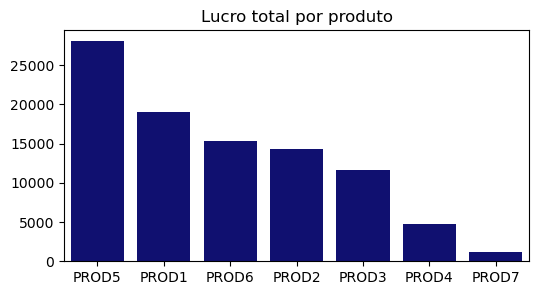

In [8]:
df_profit = monthly_profits.sort_values("total", ascending=False, axis=0).reset_index(drop=False)

fig, ax = plt.subplots(figsize=(6,3))
sns.barplot(df_profit, x="index", y="total", color='navy')
plt.xlabel("")
plt.ylabel("")
plt.title("Lucro total por produto")
plt.show()

### Capacidade das máquinas

In [9]:
machine_types = [
    'grinders', 'vertical drills', 'horizontal drills', 'borer', 'planer'
]

monthly_machine_capacity = pd.DataFrame(
    data=hours_available, index=machine_types, columns=months, dtype='int'
)
print()
print("Capacidade horária por tipo de máquina por mês")
display(monthly_machine_capacity)


Capacidade horária por tipo de máquina por mês


,M1,M2,M3,M4,M5,M6
grinders,1152,1536,1536,1536,1152,1536
vertical drills,768,768,768,384,384,768
horizontal drills,1152,384,1152,1152,1152,768
borer,384,384,0,384,384,384
planer,384,384,384,384,384,0


In [10]:
production_hours_per_unit = pd.DataFrame(
    data=production_hours, index=products, columns=machine_types, dtype='float'
)
print()
print("Horas necessárias por tipo de máquina")
display(production_hours_per_unit)


Horas necessárias por tipo de máquina


,grinders,vertical drills,horizontal drills,borer,planer
PROD1,0.5,0.1,0.2,0.05,0.00
PROD2,0.7,0.2,0.0,0.03,0.00
PROD3,0.0,0.0,0.8,0.00,0.01
PROD4,0.0,0.3,0.0,0.07,0.00
PROD5,0.3,0.0,0.0,0.10,0.05
PROD6,0.2,0.6,0.0,0.00,0.00
PROD7,0.5,0.0,0.6,0.08,0.05


Quero saber quantas horas faltam de cada máquina por mês para poder entregar
a demanda que não foi atendida

In [11]:
production_hours_per_unit.T @ monthly_leftover_demand

,M1,M2,M3,M4,M5,M6
grinders,128.40,0.0,570.0,0.0,0.0,320.0
vertical drills,22.40,0.0,120.0,0.0,0.0,0.0
horizontal drills,60.00,0.0,40.0,0.0,0.0,46.0
borer,11.36,0.0,65.0,0.0,0.0,105.8
planer,5.00,0.0,20.0,0.0,0.0,53.5


Isso não ajuda muito, porque não necessariamente eu vou querer comprar máquinas
para atender a demanda restante de todos os produtos...

In [12]:
from math import ceil

monthly_machine_hours = (
    production_hours_per_unit.T @ monthly_production
).applymap(ceil)

print("Horas utilizadas por máquina por mês")
display(monthly_machine_hours)

print()
print("Capacidade horária por tipo de máquina por mês")
display(monthly_machine_capacity)

print()
monthly_machine_percentages = (
    100*monthly_machine_hours.div(monthly_machine_capacity)
).round(1)

print("Percentual da capacidade utilizado por máquina por mês")
display(monthly_machine_percentages)

Horas utilizadas por máquina por mês


,M1,M2,M3,M4,M5,M6
grinders,1152,1105,80,420,510,770
vertical drills,438,370,240,230,230,600
horizontal drills,407,384,0,420,540,110
borer,153,123,0,82,128,69
planer,44,39,0,19,66,0



Capacidade horária por tipo de máquina por mês


,M1,M2,M3,M4,M5,M6
grinders,1152,1536,1536,1536,1152,1536
vertical drills,768,768,768,384,384,768
horizontal drills,1152,384,1152,1152,1152,768
borer,384,384,0,384,384,384
planer,384,384,384,384,384,0



Percentual da capacidade utilizado por máquina por mês


,M1,M2,M3,M4,M5,M6
grinders,100.0,71.9,5.2,27.3,44.3,50.1
vertical drills,57.0,48.2,31.2,59.9,59.9,78.1
horizontal drills,35.3,100.0,0.0,36.5,46.9,14.3
borer,39.8,32.0,NaN,21.4,33.3,18.0
planer,11.5,10.2,0.0,4.9,17.2,NaN


Vemos acima que no mês 3 não houve utilização do borer (que estava indisponível 
para manutenção de acordo enunciado do problema), e no mês 6 não foi utilizado 
o planer (também indisponível para manutenção nesse mês).

Consultando a tabela de horas necessárias por produto e tipo de máquina 
(`production_hours_per_unit`) podemos ver que essas duas máquinas são utilizadas
para a produção de PROD5, que teve uma demanda não atendida significativa nesses
meses.

Vamos ver quantas horas de cada máquina seriam necessárias para atender a demanda restante do PROD5 a cada mês

In [13]:
print("Horas necessárias por tipo de máquina")
display(production_hours_per_unit.loc[['PROD5']])

print("Demanda não atendida")
display(monthly_leftover_demand.loc[['PROD5']])

A = production_hours_per_unit.loc['PROD5']
B = monthly_leftover_demand.loc['PROD5']

print()
monthly_hours_for_leftover_prod5 = pd.DataFrame(
    data=np.outer(A, B), index=machine_types, columns=months
)
print("Horas por máquina para atender demanda restante do PROD5")
display(monthly_hours_for_leftover_prod5)

Horas necessárias por tipo de máquina


,grinders,vertical drills,horizontal drills,borer,planer
PROD5,0.3,0.0,0.0,0.1,0.05


Demanda não atendida


,M1,M2,M3,M4,M5,M6
PROD5,0,0,400,0,0,1050



Horas por máquina para atender demanda restante do PROD5


,M1,M2,M3,M4,M5,M6
grinders,0.0,0.0,120.0,0.0,0.0,315.0
vertical drills,0.0,0.0,0.0,0.0,0.0,0.0
horizontal drills,0.0,0.0,0.0,0.0,0.0,0.0
borer,0.0,0.0,40.0,0.0,0.0,105.0
planer,0.0,0.0,20.0,0.0,0.0,52.5


In [14]:
working_hours_per_month

384

Observando que tanto grinders quanto planers têm horas disponíveis de sobra no 
M3 e um novo borer teria uma capacidade mais do que suficiente para atender a 
demanda restante de PROD5, faria sentido comprar um borer adicional para atender
 a demanda do M3 (e possivelmente outras adicionais, pois sobraria capacidade).

Também observamos que no M6 sobra capacidade de grinders e borer (mesmo sem o 
adicional), e a compra de um planer adicional permitiria atender toda a demanda 
restante de PROD5.

A demanda não atendida do PROD5 no M6 é ainda maior que no M3, sendo então em 
princípio ainda mais vantajoso comprar um planer adicional em relação ao borer 
(desconsiderando os preços das máquinas, que não são conhecidos).

## Sugestões

#### 1. Aumentar o preço de PROD5, PROD1, PROD2

Esses produtos possuem os mais altos percentuais de demanda não atendida, e
altos valores de oportunidade de lucro perdida.

Portanto, mesmo que um aumento de preço reduza a demanda, ainda é provável que
reste demanda suficiente para que toda a produção seja vendida, resultando em
um lucro maior.

#### 2. Comprar um planer adicional, e possivelmente um borer

Como observamos acima, a compra de um único planer (que estivesse disponível no 
M6) permitiria atender toda a demanda restante de PROD5 nesse mês, que é a maior
 demanda não atendida num mês dentre todos os produtos, e responsável pela maior 
 fração de lucro não conquistado.

A compra de um borer adicional permitiria atender a demanda restante do mesmo 
produto no M3, que é a segunda mais relevante em número de unidades e lucro 
perdido.